# Getting Started（日本語）

## このノートブックについて

### 目的

SSH Kernelの利用に最低限必要な設定と、使い方を述べます。

### ノートブックの構成

* 説明用のSSHデーモンをDockerコンテナとして作成し、
  SSH Kernelの利用に必要な接続先ユーザ名やポートなどの設定・検証手順を述べます
* SSH Kernel独自の記法を述べ、リモートコマンド実行する手順を述べます

### ノートブック作成環境

* OS: Ubuntu 16.04
* Docker: 18.06.1-ce
* Python: 3.6.2
* Jupyter notebook: 5.7.0
* SSH Kernel: 0.6.1

## 説明用SSH接続先デーモンの起動

説明用のsshdコンテナを作成

* host: localhost
* port: 10022
* login: root
* password: root

注：localhost以外のホストで実行する場合や、ポート番号を変更する場合は、次章の説明を読み替えてください

In [11]:
! docker pull rastasheep/ubuntu-sshd:18.04

18.04: Pulling from rastasheep/ubuntu-sshd
Digest: sha256:1df808ccf95c13b8e62548ad434829bc28ee701a65624e5c0440fc24482e4a62
Status: Image is up to date for rastasheep/ubuntu-sshd:18.04


In [8]:
!docker run -d --rm -p 10022:22 rastasheep/ubuntu-sshd:18.04

41b562ffa1b35b2aea62255d7e5645bc4bb0afd7a725c06cccf3c52dcafcb1e5


In [11]:
!docker ps |grep ubuntu-sshd

41b562ffa1b3        rastasheep/ubuntu-sshd:18.04     "/usr/sbin/sshd -D"      24 seconds ago      Up 22 seconds       0.0.0.0:10022->22/tcp                                lucid_roentgen


## SSHの設定

### 接続先ユーザ名・ポート・公開鍵などの設定と確認

#### 設定ファイルの作成

ターミナルでの作業：

* 次の内容の `~/.ssh/config` ファイルを作成します

In [6]:
!head -n5 ~/.ssh/config

Host test
  Hostname localhost
  User root
  Port 10022
  IdentityFile /tmp/id_rsa_test


#### 公開鍵ペアの作成

ターミナルでの作業：

* パスフレーズ無し秘密鍵作成

```
ssh-keygen -f /tmp/id_rsa_test -t rsa -N ''

```

* ホスト鍵記憶、パスワードログインの検証

```
% ssh test
The authenticity of host '[localhost]:10022 ([::1]:10022)' can't be established.
ECDSA key fingerprint is SHA256:Rath9QRSP1hKeFkIGwL1c1WUV+haHdJrxTyilRrRNnE.
Are you sure you want to continue connecting (yes/no)? yes
Warning: Permanently added '[localhost]:10022' (ECDSA) to the list of known hosts.
root@localhost's password: 
    初期パスワード'root'と入力
root@41b562ffa1b3:~#
root@41b562ffa1b3:~# exit
logout
Connection to localhost closed.
```

* 公開鍵の登録

```
% ssh-copy-id -i /tmp/id_rsa_test test
/usr/bin/ssh-copy-id: INFO: Source of key(s) to be installed: "/tmp/id_rsa_test.pub"
/usr/bin/ssh-copy-id: INFO: attempting to log in with the new key(s), to filter out any that are already installed
/usr/bin/ssh-copy-id: INFO: 1 key(s) remain to be installed -- if you are prompted now it is to install the new keys
root@localhost's password:

Number of key(s) added: 1

Now try logging into the machine, with:   "ssh 'test'"
and check to make sure that only the key(s) you wanted were added.
```

### 設定の検証

* 次のセルの結果が uid=0(root) gid=0(root) groups=0(root) であればOK

In [7]:
!ssh test id

uid=0(root) gid=0(root) groups=0(root)


## SSH Kernelの使い方

### 概要

SSH Kernel独自の記法 `%login {host}` 以降のセルを、リモートで実行します。

リモート実行を終了するには `%logout`を実行します

In [8]:
%login test

[ssh] Login to test...
[DEBUG] host=test hostname=localhost other_conf={'user': 'root', 'port': 10022, 'keyfile': ['/tmp/id_rsa_test']}
[ssh] Successfully logged in.


In [9]:
id

[INFO] host = localhost
uid=0(root) gid=0(root) groups=0(root)


In [10]:
%logout

[ssh] Successfully logged out.


### 独自の記法

#### %login記法

`%login {host}` は、対象ホストとのSSHコネクションを生成する、SSH Kernel独自の記法です。
先に作成した`~/.ssh/config`の設定が有効です。

コネクション生成に成功すると成功メッセージが表示され、失敗するとエラーメッセージが表示されます。

#### %logout記法

`%logout` は、生成したコネクションを切断する、独自の記法です。

#### エラー例

%login前、もしくは、%logout後、に !をつけずにセル実行するとエラーメッセージが表示されます

In [12]:
id

[ssh] Not connected
Traceback (most recent call last):
  File "/home/masaru/go/src/gitlab.com/m-ueno/ssh_kernel/ssh_kernel/kernel.py", line 81, in do_execute_direct
    self.assert_connected()
  File "/home/masaru/go/src/gitlab.com/m-ueno/ssh_kernel/ssh_kernel/kernel.py", line 179, in assert_connected
    raise SSHKernelNotConnectedException
ssh_kernel.exception.SSHKernelNotConnectedException



abort: not connected

%login時に名前解決に失敗するとエラーメッセージが表示されます

In [18]:
%login notfound

[ssh] Login to notfound...
[DEBUG] host=notfound hostname=notfound other_conf={}


[ssh] Login to notfound failed.
Error in calling magic 'login' on line:
    [Errno -5] No address associated with hostname
    args: ['notfound']
    kwargs: {}
Traceback (most recent call last):
  File "/home/masaru/go/src/gitlab.com/m-ueno/ssh_kernel/env/lib/python3.6/site-packages/metakernel/magic.py", line 82, in call_magic
    func(*args, **kwargs)
  File "/home/masaru/go/src/gitlab.com/m-ueno/ssh_kernel/ssh_kernel/magics.py", line 28, in line_login
    raise e
  File "/home/masaru/go/src/gitlab.com/m-ueno/ssh_kernel/ssh_kernel/magics.py", line 25, in line_login
    self.kernel.sshwrapper.connect(host)
  File "/home/masaru/go/src/gitlab.com/m-ueno/ssh_kernel/ssh_kernel/ssh_wrapper_plumbum.py", line 88, in connect
  File "/home/masaru/go/src/gitlab.com/m-ueno/ssh_kernel/env/lib/python3.6/site-packages/plumbum/machines/paramiko_machine.py", line 261, in __init__
    self._client.connect(host, **kwargs)
  File "/home/masaru/go/src/gitlab.com/m-ueno/ssh_kernel/env/lib/python3.6/site-p

### その他

実装の仕組み上使えるものの未検証であったり主眼でない機能について触れます。

#### ! 記法

!で始まるセル内容は、ローカルシェルで実行されます。

注：この記法は、IPythonやipykernelの記法に似たものですが、IPythonやipykernelのように行内に書くことはできません

In [13]:
!id

uid=1000(masaru) gid=1000(masaru) groups=1000(masaru),4(adm),24(cdrom),27(sudo),30(dip),46(plugdev),110(lxd),115(lpadmin),116(sambashare),121(libvirtd),999(docker)


#### %python記法

In [27]:
%python x = 1+1

In [28]:
%python x

2

In [32]:
%%python

x *= 2
print('x is ' + str(x))

x is 4


#### %help

実行すると、オンラインヘルプがポップアップ表示されます.

In [30]:
%help

In [31]:
%help %login

In [33]:
%help %%python

## 制限事項

主に実装の都合により、次の制限があります。

### 対話コマンド

実行中にキー入力を待ち受ける対話コマンドは使えません。

対策：

* Jupyter Notebookの"Terminal"を使う
* `sudo`コマンドは、パスワード入力なしで実行できるよう設定を変える
* 「対話モード」の代わりに「バッチモード」で実行する
    * e.g. `top` => `top -b`
* 間違って実行してしまったら、Jupyter Notebookの「interrupt the kernel」か「restart kernel」を実行し、コマンド実行を中断する
    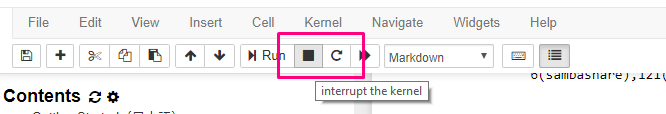

### パスワードログイン

上と同様の理由で、対象サーバへのパスワードでのログインはできません。

対策：

* SSH公開鍵認証の設定をする
+ SSH秘密鍵をパスフレーズで保護し、Jupyter Notebookをssh-agentクライアントとして起動する

### シェル変数

セルをまたぐ場合、一部のシェル変数の値が、SSH端末と異なることがあります（例：`$?`, `$$`）。
これは、コマンド実行の度に[SSHチャネル](http://docs.paramiko.org/en/2.4/api/channel.html)を生成しシェル変数がリセットされるためです。
同一セル内であればリセットされません。

### !記法

* !記法 (`%shell` magic) は[Metakernel](https://github.com/Calysto/metakernel/)の実装を利用しており、IPython Kernelの実装・挙動と異なります。